# Comparing Performance for Memory-Based SR Algs

In this notebook, the agent is trained starting in random positions to navigate from the top-left to the bottom-right of an open field. The agent operates a softmax policy with $\beta = 5$. At test time, the agent acts greedily according to its Q-function, computed as the product of its SR and its state-based reward weights learned at the training time. We compare the average episode run across a number of episodes.

Three different training algorithms are used: SR-SARSA, SR-Dyna, SR-PS, and SR-MD. Each is trained with the same number of episodes, and additionally use the same number of memory iterations. We also provide visualizations of which states were most frequently recalled for both SR-Dyna and SR-PS.

In [1]:
import numpy as np
import numpy.random as npr
from gridworld import SimpleGrid
from algs import TDSR
import progressbar
from plotting import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from utils import exp_normalize, memory_update, get_dyna_indices, get_predecessors, PriorityQueue

npr.seed(0)

In [2]:
grid_size = 7
pattern="four_rooms" # "empty" or "four_rooms" or "random"
env = SimpleGrid(grid_size, block_pattern=pattern, obs_mode="index")

In [3]:
# env episode params
episode_length = (10 * grid_size)
episodes_train = 100
episodes_test  = 1000
agent_pos = [0, 0]
goal_pos = [grid_size -1, grid_size -1]

# all agent params
gamma = 0.99
lr = 1e-1 # learning rate across all incremental algs
poltype = 'softmax' # "egreedy" or "softmax"
epsilon_train = 1 # for epsilon-greedy policies
beta_train = 5 # inverse temperature for softmax policies
epsilon_test = 0
beta_test = 1e6

# memory params
n_mem_dyna = 10 # number of retrieved memories per timestep
n_mem_ps = 10
n_mem_md = 10
theta = 1e-5 # priority threshold for prioritized sweeping

# plotting params 
cmap = copy.copy(mpl.cm.get_cmap("viridis"))
cmap.set_bad(color="white")

## Training Phase

### No Memory

In [4]:
agent_nomem = TDSR(env.state_size, env.action_size, lr, gamma, poltype=poltype)
experiences = []
errors = []

for i in progressbar.progressbar(range(episodes_train)):
    
    env.reset(goal_pos=goal_pos)
    state = env.observation

    for j in range(episode_length):
        action = agent_nomem.sample_action(state, epsilon=epsilon_train, beta=beta_train)
        reward = env.step(action)
        state_next = env.observation
        done = env.done
        experiences.append([state, action, state_next, reward, done])        
        state = state_next
        
        if (j > 1):
            td_sr = agent_nomem.update_sr(experiences[-2], experiences[-1])
            errors.append(np.linalg.norm(td_sr))
            td_w = agent_nomem.update_w(experiences[-1])
                         
        if env.done:
            td_sr = agent_nomem.update_sr(experiences[-1], experiences[-1])
            errors.append(np.linalg.norm(td_sr))
                        
        if env.done:
            break

100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


### Dyna

In [5]:
agent_dyna = TDSR(env.state_size, env.action_size, lr, gamma, poltype=poltype)
experiences = []
exp_weights = []
errors = []
prioritized_states = np.zeros(env.state_size)

for i in progressbar.progressbar(range(episodes_train)):
    
    env.reset(goal_pos=goal_pos)
    state = env.observation

    for j in range(episode_length):
        action = agent_dyna.sample_action(state, epsilon=epsilon_train, beta=beta_train)
        reward = env.step(action)
        state_next = env.observation
        done = env.done
        experiences.append([state, action, state_next, reward, done])        
        state = state_next
        
        if (j > 1):
            td_sr = agent_dyna.update_sr(experiences[-2], experiences[-1])
            errors.append(np.linalg.norm(td_sr))
            td_w = agent_dyna.update_w(experiences[-1])
                         
        if env.done:
            td_sr = agent_dyna.update_sr(experiences[-1], experiences[-1])
            errors.append(np.linalg.norm(td_sr))
            
        exp_weights.append(len(experiences))
        mem_indices = get_dyna_indices(experiences, exp_weights, n_mem_dyna)
        mem = [experiences[t] for t in mem_indices]
        for exp in mem:
            prioritized_states[exp[0]] += 1
            td_sr = memory_update(exp, agent_dyna)
                        
        if env.done:
            break

100% (100 of 100) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


### Visualize Prioritized States

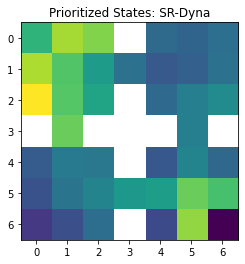

In [6]:
plt.imshow(utils.mask_grid(prioritized_states.reshape(grid_size, grid_size), env.blocks), cmap=cmap);
plt.title('Prioritized States: SR-Dyna');

### Prioritized Sweeping

In [7]:
agent_ps = TDSR(env.state_size, env.action_size, lr, gamma, poltype=poltype)
experiences = []
pqueue = PriorityQueue()
errors = []
prioritized_states = np.zeros(env.state_size)

for i in progressbar.progressbar(range(episodes_train)):
    
    env.reset(goal_pos=goal_pos)
    state = env.observation

    for j in range(episode_length):
        action = agent_ps.sample_action(state, epsilon=epsilon_train, beta=beta_train)
        reward = env.step(action)
        state_next = env.observation
        done = env.done
        experiences.append([state, action, state_next, reward, done])        
        state = state_next
        
        if (j > 1):
            td_sr = agent_ps.update_sr(experiences[-2], experiences[-1])
            errors.append(np.linalg.norm(td_sr))
            if (np.linalg.norm(td_sr) > theta):
                pqueue.push(experiences[-2], -np.linalg.norm(td_sr))
            td_w = agent_ps.update_w(experiences[-1])
                         
        if env.done:
            td_sr = agent_ps.update_sr(experiences[-1], experiences[-1])
            errors.append(np.linalg.norm(td_sr))
            if (np.linalg.norm(td_sr) > theta):
                pqueue.push(experiences[-1], -np.linalg.norm(td_sr))
            
        for k in range(n_mem_ps):
            
            if pqueue.is_empty():
                break

            # get highest priority item and remove
            exp = pqueue.pop()
            
            prioritized_states[exp[0]] += 1

            td_sr = memory_update(exp, agent_ps)                

            for exp_pred in get_predecessors(exp[0], experiences):
                td_sr = memory_update(exp_pred, agent_ps)                    
                if (np.linalg.norm(td_sr) > theta):
                    pqueue.push(exp_pred, -np.linalg.norm(td_sr))
                        
        if env.done:
            break

100% (100 of 100) |######################| Elapsed Time: 0:00:31 Time:  0:00:31


### Visualize Prioritized States

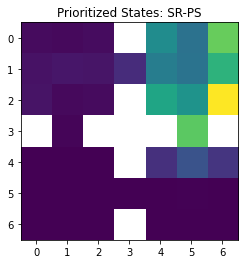

In [8]:
plt.imshow(utils.mask_grid(prioritized_states.reshape(grid_size, grid_size), env.blocks), cmap=cmap);
plt.title('Prioritized States: SR-PS');

### MD

In [9]:
agent_md = TDSR(env.state_size, env.action_size, lr, gamma, poltype=poltype)
experiences = []
errors = []
prioritized_states = np.zeros(env.state_size)

for i in progressbar.progressbar(range(episodes_train)):
    
    env.reset(goal_pos=goal_pos)
    state = env.observation

    for j in range(episode_length):
        action = agent_md.sample_action(state, epsilon=epsilon_train, beta=beta_train)
        reward = env.step(action)
        state_next = env.observation
        done = env.done
        experiences.append([state, action, state_next, reward, done])        
        state = state_next
        
        if (j > 1):
            td_sr = agent_md.update_sr(experiences[-2], experiences[-1])
            errors.append(np.linalg.norm(td_sr))
            td_w = agent_md.update_w(experiences[-1])
                         
        if env.done:
            td_sr = agent_md.update_sr(experiences[-1], experiences[-1])
            errors.append(np.linalg.norm(td_sr))
            
        unique_exps = list(set([tuple(exp) for exp in experiences]))
            
        for k in range(n_mem_md):
            evbs = [{"exp": list(exp), "evb": agent_md.evb(state, list(exp), epsilon=epsilon_train, beta=beta_train)} for exp in unique_exps]
            best = sorted(evbs, key=lambda x: x["evb"]).pop()
            best_exp = best["exp"]
            prioritized_states[best_exp[0]] += 1
            td_sr = memory_update(best_exp, agent_md)
            
        if env.done:
            break

100% (100 of 100) |######################| Elapsed Time: 0:13:15 Time:  0:13:15


### Visualize Prioritized States

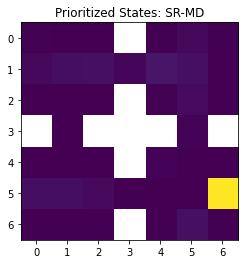

In [10]:
plt.imshow(utils.mask_grid(prioritized_states.reshape(grid_size, grid_size), env.blocks), cmap=cmap);
plt.title('Prioritized States: SR-MD');

## Test Phase

In [11]:
ep_lengths = []
errors = []

for i in progressbar.progressbar(range(episodes_test)):
    
    ep_experiences = []
    env.reset(agent_pos=agent_pos, goal_pos=goal_pos)
    state = env.observation

    for j in range(episode_length):
        action = agent_nomem.sample_action(state, epsilon=epsilon_test, beta=beta_test)
        reward = env.step(action)
        state_next = env.observation
        done = env.done
        ep_experiences.append([state, action, state_next, reward, done])        
        state = state_next
                        
        if env.done:
            break
            
    ep_lengths.append(len(ep_experiences))
            
av_ep_length_nomem = np.mean(ep_lengths)

100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02


In [12]:
ep_lengths = []
errors = []

for i in progressbar.progressbar(range(episodes_test)):
    
    ep_experiences = []
    env.reset(agent_pos=agent_pos, goal_pos=goal_pos)
    state = env.observation

    for j in range(episode_length):
        action = agent_dyna.sample_action(state, epsilon=epsilon_test, beta=beta_test)
        reward = env.step(action)
        state_next = env.observation
        done = env.done
        ep_experiences.append([state, action, state_next, reward, done])        
        state = state_next
                        
        if env.done:
            break
        
    ep_lengths.append(len(ep_experiences))
            
av_ep_length_dyna = np.mean(ep_lengths)

100% (1000 of 1000) |####################| Elapsed Time: 0:00:05 Time:  0:00:05


In [13]:
ep_lengths = []
errors = []

for i in progressbar.progressbar(range(episodes_test)):
    
    ep_experiences = []
    env.reset(agent_pos=agent_pos, goal_pos=goal_pos)
    state = env.observation

    for j in range(episode_length):
        action = agent_ps.sample_action(state, epsilon=epsilon_test, beta=beta_test)
        reward = env.step(action)
        state_next = env.observation
        done = env.done
        ep_experiences.append([state, action, state_next, reward, done])        
        state = state_next
                        
        if env.done:
            break
            
    ep_lengths.append(len(ep_experiences))
            
av_ep_length_ps = np.mean(ep_lengths)

100% (1000 of 1000) |####################| Elapsed Time: 0:00:05 Time:  0:00:05


In [14]:
ep_lengths = []
errors = []

for i in progressbar.progressbar(range(episodes_test)):
    
    ep_experiences = []
    env.reset(agent_pos=agent_pos, goal_pos=goal_pos)
    state = env.observation

    for j in range(episode_length):
        action = agent_md.sample_action(state, epsilon=epsilon_test, beta=beta_test)
        reward = env.step(action)
        state_next = env.observation
        done = env.done
        ep_experiences.append([state, action, state_next, reward, done])        
        state = state_next
                        
        if env.done:
            break
            
    ep_lengths.append(len(ep_experiences))
            
av_ep_length_md = np.mean(ep_lengths)

100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


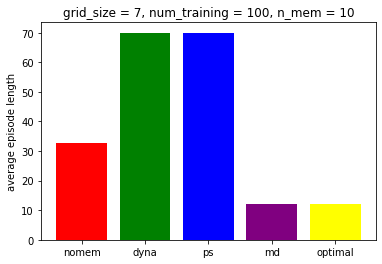

In [15]:
color = ['red', 'green', 'blue', 'purple', 'yellow']
plt.bar(['nomem', 'dyna', 'ps', 'md', 'optimal'], [av_ep_length_nomem, av_ep_length_dyna, av_ep_length_ps, av_ep_length_md, 2 * (grid_size - 1)], color=color);
plt.title(f'grid_size = {grid_size}, num_training = {episodes_train}, n_mem = {n_mem_dyna}');
plt.ylabel('average episode length');